In [1]:
'''
Aim: prepare panels of figure 3 in the manuscript
Date: May/2023
Author: Yike Xie
'''

'\nAim: prepare panels of figure 3 in the manuscript\nDate: May/2023\nAuthor: Yike Xie\n'

optical features vs gene expression has been done in figure 2 [spectra_norm vs gene exp]

In [2]:
import os
import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns

import scanpy as sc
import pickle

In [3]:
def sig_dataset(feas_fn, data_fn):
    print('load features')
    with open(feas_fn, 'rb') as f:
        features = pd.read_pickle(f)
    features.set_index('image', inplace=True)
    
    print('load dataset')
    adata = sc.read_h5ad(data_fn)
    sc.pp.normalize_total(adata, target_sum=1e6)
    
    print('filter single cells')
    adata = adata[adata.obs['doublets'] != 'Yes']

#     print('filter genes')
#     sc.pp.filter_genes(adata, min_cells=10)

    print('Add features to adata')
    for col in features.columns:
        adata.obs[col] = features.loc[adata.obs_names][col]

    return adata

def get_correlation(adata, feas):
    
    exp = adata.X.T
    phe = adata.obs[feas].fillna(0)

    x = exp
    y = phe.values.T

    from scipy.stats import rankdata

    xw = np.zeros_like(x, float)
    for ii, xi in enumerate(x):
        xw[ii] = rankdata(xi, method='average')
    yw = np.zeros_like(y, float)
    for ii, yi in enumerate(y):
        yw[ii] = rankdata(yi, method='average')

    xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
    yw = ((yw.T - yw.mean(axis=1)) / yw.std(axis=1)).T
    n = xw.shape[1]
    r = np.dot(xw, yw.T) / n

    corr = pd.DataFrame(
                    data=r,
                    index=adata.var_names,
                    columns=phe.columns,
                    dtype=float)

    return corr

def plot_correlation(genes, adata, fea, xlabel, path, filetype=False):
    
    import itertools
    n_genes = len(list(itertools.chain.from_iterable(genes.values())))
    colors = sns.color_palette('tab10', n_genes)
    colors = [colors[: len(genes['positive'])], colors[len(genes['positive']):]]

    fig, axs = plt.subplots(2, 1, figsize=(4, 6), dpi=300)
    rcParams['pdf.fonttype'] = 42
    rcParams['font.sans-serif'] = "Arial"
    
    for j, (ax, genes) in enumerate(zip(axs, [genes['positive'], genes['negative']])):
        for ig, gene in enumerate(genes):
            x = adata.obs[fea]
            y = adata[:, gene].X + 0.1
            idx = np.argsort(x)
            ax.scatter(
                x[idx], y[idx], alpha=0.8, label=gene, lw=2, color=colors[j][ig], s=10, 
            )
        ax.legend(fontsize=8, bbox_to_anchor=(1, 1))
        ax.set_xlabel(xlabel)
        ax.set_ylabel('Gene exp [cpm]')
        ax.set_yscale('log')
#         ax.set_xscale('log')
        
    axs[0].set_title('Positive correlation')
    axs[1].set_title('Negative correlation')
    fig.tight_layout()

    if filetype is not False:
        plt.savefig(save_figures + fea + filetype)
    
    return {'fig': fig, 'axs': axs}

def plot_bins(adata, fea, bin_n, gene, cmap, filetype, path=False):
    area_order = adata.obs[fea].sort_values().index
    exp = adata[area_order, gene].X
    exp = pd.DataFrame(exp[:,0], index=area_order, columns=['Gene exp [cpm]'])

    exp['order'] = '0'
    for i in range(bin_n):
        n = round(exp.shape[0] / bin_n)
        idx = [j for j in np.arange(n) + n * i if j < exp.shape[0]]
        exp.loc[area_order[idx], 'order'] = 'Group {}'.format(str(i + 1))

    fig, ax = plt.subplots(figsize=[2, 3])
    rcParams['pdf.fonttype'] = 42
    rcParams['font.size'] = 10
    med = [exp[exp['order'] == 'Group {}'.format(str(i + 1))]['Gene exp [cpm]'].median()
           for i in range(bin_n)]
    alpha = [0.2 + 0.6 * i/max(med) for i in med]
    cmap = mpl.cm.get_cmap(cmap)
    palette = [cmap(i) for i in alpha]

    PROPS = {
        'boxprops':{'edgecolor':'white'},
        'medianprops':{'color':'white'},
        'whiskerprops':{'color':'none'},
        'capprops':{'color':'none'}}
    sns.boxplot(data=exp, x='order', y='Gene exp [cpm]', palette=palette, **PROPS)
    sns.stripplot(data=exp, x='order', y='Gene exp [cpm]', palette=palette, edgecolor='white', linewidth=1, size=3)
    ax.set_xticks([])
    ax.set_xticklabels([])
    ax.set_xlabel('{}:\nsmallest → largest'.format([fea.title(), fea][fea.isupper()]))
    ax.set_title(gene)
    ax.set_yscale('log')

    if path is not False:
        fig.savefig(os.path.join(path, f'{fea}_{gene}{filetype}'), dpi=300, bbox_inches='tight')
        
    return {'fig': fig, 'ax': ax}

def save_PC_frac_genes(corr, PC, fea, threshold):
    res = []

    for f in corr[fea].sort_values().unique():
        df_f = corr[(corr[fea] == f)]
        hmax = df_f[PC].quantile(threshold)
        hmin = df_f[PC].quantile(1 - threshold)

        ups = df_f[df_f[PC] >= hmax].index
        downs = df_f[df_f[PC] <= hmin].index

        feas = {
            fea: f,
            'up_genes': ups, 
            'down_genes': downs, 
            'hmax': hmax, 
            'hmin': hmin,
        }
        res.append(feas)

    res = pd.DataFrame(res)
    
    return res

In [5]:
feas_fn = '/home/yike/phd/cancer_cells_img_seq/figures/batch_202112/segmentation/background_subtraction/bkg_sub_features.pkl'
data_fn = '/home/yike/phd/cancer_cells_img_seq/data/20220201_NextSeq/gene_filter.h5ad'
adata = sig_dataset(feas_fn, data_fn)
# adata.obs['spectra_norm'] = np.array(adata.obs['spectra'].tolist()).mean(axis=1) / adata.obs['area']

save_figures = '/home/yike/phd/cancer_cells_img_seq/figures/batch_202112/hyperspectral_images/correlate_features/PCA_gene/'

/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)
Trying to set attribute `.obs` of view, copying.


load features
load dataset
filter single cells
Add features to adata


## PCA on 15 pectras and select components with high variances

In [6]:
# load results of PCA analysis
components = pd.read_csv(save_figures + 'PCA_components.tsv', sep='\t', index_col=0)
X_r = pd.read_csv(save_figures + 'PCA_15PC.tsv', sep='\t')

In [9]:
if False:
    df = pd.DataFrame(index=adata.obs_names, columns=adata.obs['wavelengths'].iloc[0])
    for i in df.index:
        df.loc[i] = adata.obs['spectra'].loc[i] / adata.obs['area'].loc[i]

    from sklearn.decomposition import PCA
    X = df.values
    pca = PCA()
    X_r = pca.fit(X).transform(X)


    PCA_df = pd.DataFrame(X_r, index=df.index, columns=['PC{}'.format(str(i + 1)) for i in range(15)])
    PCA_df.loc['exp_var'] = pca.explained_variance_ratio_
    PCA_df.to_csv(save_figures + 'PCA_15PC.tsv', sep='\t')
    
    components = pd.DataFrame(pca.components_, index=['PC{}'.format(str(i)) for i in range(1, 16)],
             columns=adata.obs['wavelengths'].iloc[0])
    components.to_csv(save_figures + 'PCA_components.tsv', sep='\t')

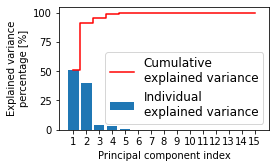

In [8]:
exp_var = pca.explained_variance_ratio_ * 100
cum_exp_var = np.cumsum(exp_var)

fig, ax = plt.subplots(figsize=[4, 2.5])
rcParams['pdf.fonttype'] = 42
rcParams['font.size'] = 12
ax.bar(range(1, len(exp_var) + 1), exp_var, align='center',
        label='Individual\nexplained variance')
ax.step(range(1, len(exp_var) + 1), cum_exp_var, where='mid',
         label='Cumulative\nexplained variance', color='red')

ax.set_ylabel('Explained variance\npercentage [%]')
ax.set_xlabel('Principal component index')
ax.set_xticks(ticks=range(1, len(exp_var) + 1))
ax.legend(loc='best', fontsize=12)
fig.tight_layout()
fig.savefig(save_figures + 'PCA_exp_vars.pdf', dpi=300, bbox_inches='tight')
fig.savefig(save_figures + 'PCA_exp_vars.png', dpi=300, bbox_inches='tight')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


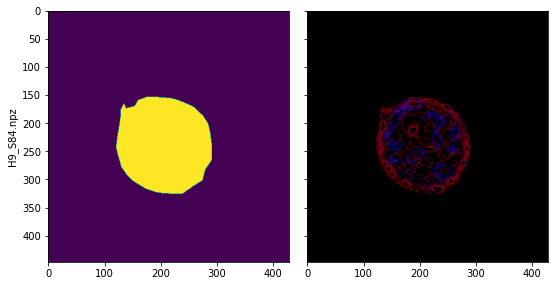

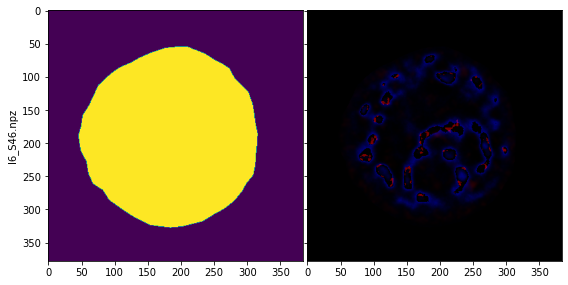

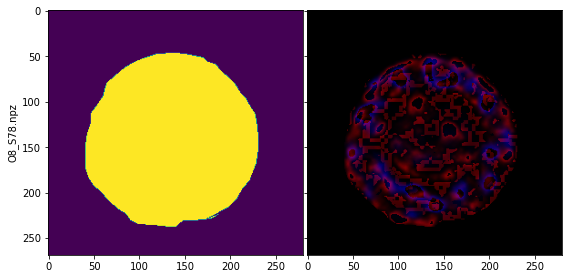

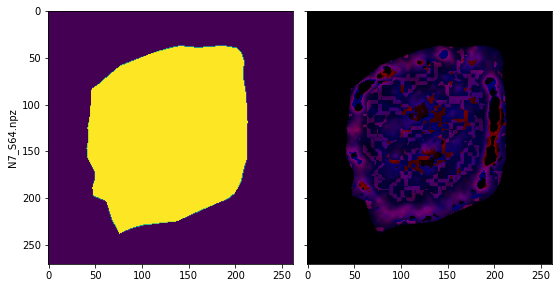

In [112]:
npz_fdn = '/home/yike/phd/cancer_cells_img_seq/figures/segmentation/cancer100cells/'
save_path = '/home/yike/phd/cancer_cells_img_seq/docs/hyperspectral_sequencing_ewa/figures/figure1/'

    
newcols = ['_'.join(['wls'] + x.strip('()').split(', ')) for x in components.columns]
pcs = ['PC1', 'PC2']


fns = os.listdir(npz_fdn)[:5]
fns = [
    X_r.set_index('cell_name')["PC1"].nsmallest(10).index[3] + ".npz",
    X_r.set_index('cell_name')["PC1"].nlargest(10).index[3] + ".npz",
    X_r.set_index('cell_name')["PC2"].nsmallest(10).index[3] + ".npz",
    X_r.set_index('cell_name')["PC2"].nlargest(10).index[3] + ".npz",
]
       

for i, fn in enumerate(fns):
    image = np.load(npz_fdn + fn)
    image_PCs = np.zeros([3] + list((image[newcols[0]]).shape), np.int8)
    image_PCs_separate = {pc: np.zeros([3] + list((image[newcols[0]]).shape), np.int8) for pc in pcs}
    for k, pc in enumerate(pcs):
        ima = np.zeros_like(image['segmentation'], np.float64) 
        for i, wl in enumerate(newcols):
            ima += components.iloc[:, i].loc[pc] * image[wl]
        ima *= image["new_segmentation"]
        
        # For the separate plots, put positive numbers in red channel and negative in blue channel
        ima_sep = ima.copy()
        ima_sep[ima < 0] = 0
        ima_sep = ima_sep**2
        if ima_sep.max() > 0:
            ima_sep = (2**8 - 1) * ima_sep / ima_sep.max()
        image_PCs_separate[pc][0] = ima_sep.astype(np.int8)
        
        ima_sep = ima.copy()
        ima_sep[ima > 0] = 0
        ima_sep = -ima_sep
        ima_sep = ima_sep**2
        if ima_sep.max() > 0:
            ima_sep = (2**8 - 1) * ima_sep / ima_sep.max()
        image_PCs_separate[pc][2] = ima_sep.astype(np.int8)
        
        # For the general plot, take the square
        ima *= ima
        ima = (2**8 - 1) * ima / ima.max()
        image_PCs[k * 2] = ima.astype(np.int8)

    image_PCs = image_PCs.swapaxes(0, 1).swapaxes(1, 2)
    
    if True:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)
        ax1.set_ylabel(fn)
        ax1.imshow(image['new_segmentation'])
        ax2.imshow(image_PCs[:, :, :])
        fig.tight_layout(w_pad=0.1)
    
    if False:
        fig, (ax1, ax2, ax3, ax4, axpc1, axpc2) = plt.subplots(1, 6, figsize=(16, 3), sharex=True, sharey=True)
        ax1.set_ylabel(fn)
        ax1.imshow(image['new_segmentation'])
        ax2.imshow(image_PCs[:, :, :])
        ax3.imshow(image_PCs[:, :, 0], cmap='Greys_r')
        ax4.imshow(image_PCs[:, :, 2], cmap='Greys_r')
        axpc1.imshow(image_PCs_separate["PC1"].swapaxes(0, 1).swapaxes(1, 2))
        axpc2.imshow(image_PCs_separate["PC2"].swapaxes(0, 1).swapaxes(1, 2))
        fig.tight_layout(w_pad=0.1)



In [105]:
X_r.set_index('cell_name')["PC1"].idxmax()

'M4_S24'

In [70]:
    ima = np.zeros_like(image['segmentation'], np.float64) 
    for i, wl in enumerate(newcols):
        ima += components.iloc[:, i].loc[pc] * image[wl]
    ima *= image["new_segmentation"]
    ima = (ima - ima.min()) / (ima.max() - ima.min())
    ima.min()

0.0

In [42]:
np.abs(image_PCs)

array([[[16909.22101723,  6319.71369733,     0.        ],
        [15619.83223055,  6363.06471305,     0.        ],
        [13768.00812013,  6736.38716124,     0.        ],
        ...,
        [35910.66605845,  8341.51029697,     0.        ],
        [36121.58721201,  8826.73135918,     0.        ],
        [35542.59876897,  8528.24654581,     0.        ]],

       [[16963.82658319,  6268.7682039 ,     0.        ],
        [15249.19821495,  6408.64471753,     0.        ],
        [13804.32474597,  6956.76449519,     0.        ],
        ...,
        [36296.68166303,  8424.16852065,     0.        ],
        [36082.06571855,  8743.55337407,     0.        ],
        [36007.4433878 ,  8621.63255354,     0.        ]],

       [[16160.67320475,  6083.62888923,     0.        ],
        [14739.42217345,  6379.60899699,     0.        ],
        [13163.35141197,  6616.03097162,     0.        ],
        ...,
        [36235.32773475,  8216.92758398,     0.        ],
        [36105.85900473,  864

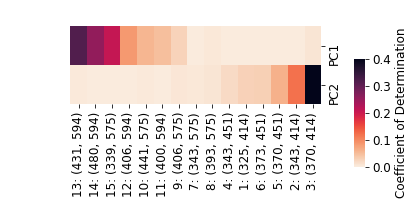

In [10]:
# wl_index = [
#     '(343, 575)', '(343, 451)', '(373, 451)','(370, 414)',  '(343, 414)', '(370, 451)', '(325, 414)','(393, 575)',  
#     '(431, 594)', '(480, 594)', '(339, 575)', '(406, 594)', '(441, 575)', '(400, 594)', '(406, 575)', # PC1
#             ]
df = pow(components.loc[['PC1', 'PC2']], 2).T.clip(0, 0.4)
idx = df[8:].sort_values('PC1', ascending=False).index.tolist() + df[:8].sort_values('PC2').index.tolist()
wl_index = [i for i in idx]
df = df.loc[wl_index]
index = [['', ' '][list(components.columns).index(i) + 1 < 10] + str(list(components.columns).index(i) + 1) + ': ' + i 
         for i in wl_index]
df.index = index

rcParams['pdf.fonttype'] = 42
g = sns.clustermap(df.T, col_cluster=False, row_cluster=False,
                vmin=0, vmax=0.4, cbar_pos=[1, 0.2, 0.03, 0.5],
                cbar_kws={'label':'Coefficient of Determination'}, cmap='rocket_r',
                figsize=[5, 3])
# g.fig.text(0.1, 0.82, 'Coefficient of Determination')
g.savefig(save_figures + 'square_R2.pdf', dpi=150, bbox_inches='tight')

In [38]:
PCA_df = pd.read_csv(save_figures + 'PCA_15PC.tsv', sep='\t', index_col=0)

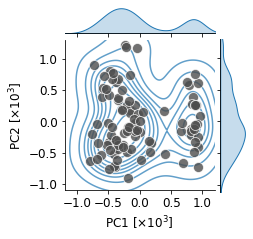

In [175]:
g = sns.JointGrid(data=PCA_df/10e3, x='PC1', y='PC2')

g.plot_joint(sns.scatterplot, s=100, color=[0.3]*3, alpha=0.8)
g.plot_joint(sns.kdeplot, zorder=-1, alpha=0.7)
g.plot_marginals(sns.kdeplot, cmap='tab10', fill=True, bw_method=0.3)

g.ax_joint.set_aspect('equal', adjustable='box')
g.ax_joint.set(xlabel='PC1 [×$10^3$]', ylabel='PC2 [×$10^3$]',
               xlim=[-1.2, 1.2], ylim=[-1.1, 1.3])
g.ax_joint.set_xticks([-1, -0.5, 0, 0.5, 1])
g.ax_joint.set_yticks([-1, -0.5, 0, 0.5, 1])

figure = plt.gcf()
figure.set_size_inches(3, 3)

plt.savefig(save_figures + 'PCA_2d.pdf', bbox_inches='tight')
plt.savefig(save_figures + 'PCA_2d.png', bbox_inches='tight')

## correlation between PC1, PC2 with gene expression

In [12]:
PCA_df = pd.read_csv(save_figures + 'PCA_15PC.tsv', sep='\t', index_col=0)

# compute the correlations between PC1, PC2 and gene expression
feas = ['PC1', 'PC2']
# add PC1 and PC2 to dataset
adata.obs['PC1'] = PCA_df[: -1].loc[adata.obs_names]['PC1']
adata.obs['PC2'] = PCA_df[: -1].loc[adata.obs_names]['PC2']

corr = get_correlation(adata, feas)
corr['Frac'] = 100 * (adata[:, corr.index].X > 0).sum(axis=0) / 95
corr['Number'] = (adata[:, corr.index].X > 0).sum(axis=0)
corr.to_csv(save_figures + 'correlation_PCA.tsv', sep='\t')

<ipython-input-3-73935c2876cc>:40: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)
/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)


### genes filtered via coefficients of correlation

In [42]:
def ellipse_settings(df, PC1, PC2, threshold):
    # parameters of ellipse
    xr = df[PC1][df[PC1] > 0].quantile(1 - threshold)
    xl = df[PC1][df[PC1] < 0].quantile(threshold)
    x0 = (xr + xl) / 2 # x-position of the center

    yr = df[PC2][df[PC2] > 0].quantile(1 - threshold)
    yl = df[PC2][df[PC2] < 0].quantile(threshold)
    y0 = (yr + yl) / 2 # y-position of the center

    a = (abs(xr) + abs(xl))  # radius on the x-axis
    b = (abs(yr) + abs(yl))  # radius on the y-axis

    x, y = df[[PC1, PC2]].values.T
    theta = np.arctan(((x -x0) * (y - y0)).mean()/((x - x0) * (x - x0)).mean()) / np.pi * 180 # Ordinary least squares
    
    cos_angle = np.cos(np.radians(180. - theta))
    sin_angle = np.sin(np.radians(180. - theta))
    xc = x - x0
    yc = y - y0
    xct = xc * cos_angle - yc * sin_angle
    yct = xc * sin_angle + yc * cos_angle 
    rad_cc = (xct**2/(a/2)**2) + (yct**2/(b/2)**2) # rad_cc > 1 means outside of the ellipse
    out_ellipse_idx = np.where(rad_cc >= 1)[0]
    
    # PC1: 0.25 and PC2: 0.1 is self defined
    orange_idx = list(set(out_ellipse_idx) & 
                      set(np.where(df[PC1] >= 0.25)[0]) )
    navy_idx = list(set(out_ellipse_idx) & 
                    set(np.where(df[PC1] <= -0.25)[0]))
    purple_idx = list(set(out_ellipse_idx) & 
                      set(np.where((-0.1 > df[PC2]) & (-0.25 < df[PC1]) & (0.25 > df[PC1]))[0]))
    red_idx = list(set(out_ellipse_idx) & 
                   set(np.where((0.1 < df[PC2]) & (-0.25 < df[PC1]) & (0.25 > df[PC1]))[0]))
    
    df['ellipse'] = 'gray'
    df.loc[df.index[orange_idx], 'ellipse'] = 'orange'
    df.loc[df.index[navy_idx], 'ellipse'] = 'navy'
    df.loc[df.index[purple_idx], 'ellipse'] = 'purple'
    df.loc[df.index[red_idx], 'ellipse'] = 'red'
    
    return {'df': df, 'xy': (x0, y0), 'theta': theta, 'width': a, 'height': b}

def plot_ellipse2(df, xy, theta, width, height, PC1, PC2, genes, alpha=0.32):
    # plot
    fig, ax = plt.subplots(figsize=[4, 2.5])
    from matplotlib.patches import Ellipse

    rgb = list(mpl.colors.to_rgba('grey'))[:-1]
    ellipse = Ellipse(xy=xy, angle=theta, width=width, height=height, edgecolor='k',
                      facecolor=tuple(rgb + [0.1]), ls='--', lw=0.5, zorder=0.5)
    ax.add_patch(ellipse)
    
    sns.scatterplot(data=df, x=PC1, y=PC2, hue='ellipse', 
                    palette=['gray', 'orange', 'navy', 'purple', 'green'], 
                    hue_order=['gray', 'orange', 'navy', 'purple', 'red'], alpha=alpha, ax=ax)

    sns.kdeplot(data=df, x=PC1, y=PC2, fill=False, cmap='rocket_r') #cmap='rocket_r'
    
    # genes
    sns.scatterplot(data=df.loc[genes], x=PC1, y=PC2, color='red')
    for gene in genes:
        x = df.loc[gene, PC1]
        y = df.loc[gene, PC2]
        ax.annotate(gene, xy=(x, y),
                    xytext=(x+0.05, y),
                    va='center', ha='left', color='k')
    ax.set_aspect('equal', adjustable='datalim')
    ax.set_xlim(-0.8, 0.8)
    ax.set_xticks([-0.75, -0.5, -0.25, 0, 0.25, 0.5, 0.75])
    ax.set_xticklabels([-0.75, -0.5, -0.25, 0, 0.25, 0.5, 0.75])
    
    ax.set_ylim(-0.5, 0.5)
    ax.set_yticks([-0.5, -0.25, 0, 0.25, 0.5])
    ax.set_yticklabels([-0.5, -0.25, 0, 0.25, 0.5])
    
    ax.axvline(0, color='gray', zorder=0.5, ls='--', lw=1)
    ax.axhline(0, color='gray', zorder=0.5, ls='--', lw=1)

    ax.set(xlabel=r'$\rho$ [{} vs gene exp]'.format(PC1), ylabel=r'$\rho$ [{} vs gene exp]'.format(PC2))
    ax.legend().remove()
    
    return {'fig': fig, 'ax': ax}

In [11]:
df = corr[corr['Number'] >= 10]
PC1, PC2 = 'PC1', 'PC2'
threshold = 0.01

ellipse_res = ellipse_settings(df, PC1, PC2, threshold)
df_ellipse, xy, theta, width, height = ellipse_res['df'], ellipse_res['xy'], ellipse_res['theta'], ellipse_res['width'], ellipse_res['height']

<ipython-input-9-35b3a1f35938>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ellipse'] = 'gray'


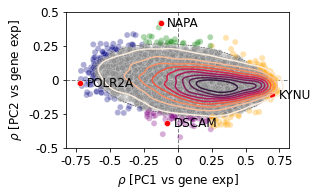

In [43]:
fig = plot_ellipse2(df_ellipse, xy, theta, width, height, PC1, PC2, ['KYNU', 'DSCAM', 'POLR2A', 'NAPA'])['fig']
fig.savefig(save_figures + 'scatter_PC12.pdf', dpi=150, bbox_inches='tight')
fig.savefig(save_figures + 'scatter_PC12.png', dpi=150, bbox_inches='tight')

In [26]:
ellipse_genes = {}

for key in ['orange', 'navy', 'purple', 'red']:
    ellipse_genes[key] = df[df['ellipse'] == key].index.tolist()

In [27]:
import gseapy as gp

def pathway_df(gene_list):    
    pthw = gp.enrichr(gene_list=gene_list,
                         gene_sets=['GO_Biological_Process_2021'], ## KEGG for metabolism
                         description='pathway',
                         cutoff = False).res2d

    pthw_plot = pthw[:10]
    pthw_plot['-log10(P-value)'] = -np.log10(pthw_plot['P-value'])
    
    return pthw_plot

In [28]:
threshold = 0.01
gene_n = 10

ellipse_show = {}
for key in ['orange', 'navy', 'purple', 'red']:
    ellipse_show[key] = pathway_df(ellipse_genes[key])
    ellipse_show[key].to_csv(save_figures + '{}_pathway_gene_{}_quartile{}.tsv'.format(key, threshold, gene_n), 
                             sep='\t')

/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/gseapy/enrichr.py:427: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.results = self.results.append(res, ignore_index=True)
2023-05-24 09:54:16,875 Warning: No enrich terms using library GO_Biological_Process_2021 when cutoff = False
<ipython-input-27-42ec577ea9ae>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pthw_plot['-log10(P-value)'] = -np.log10(pthw_plot['P-value'])
/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/gseapy/enrichr.py:427: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.resul

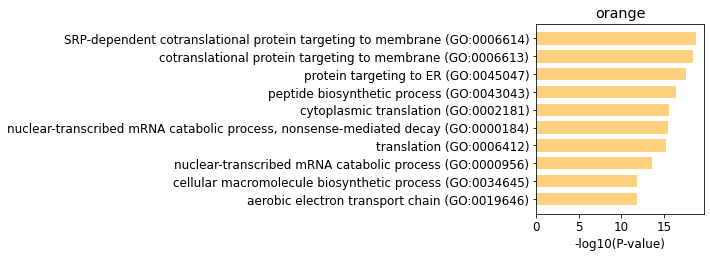

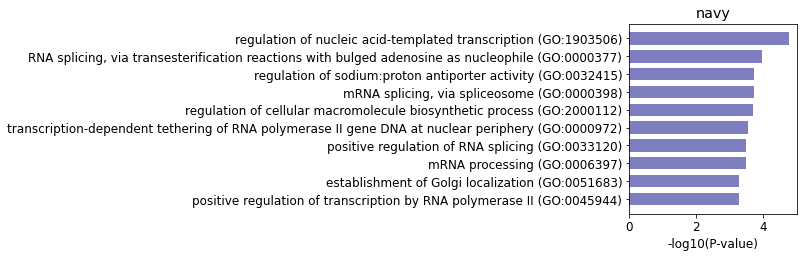

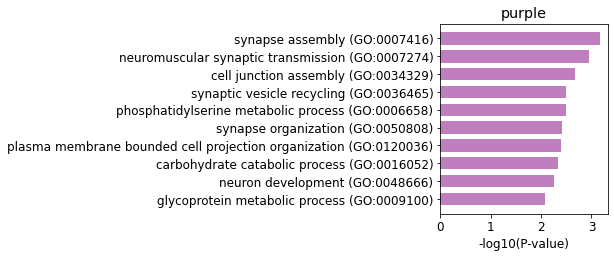

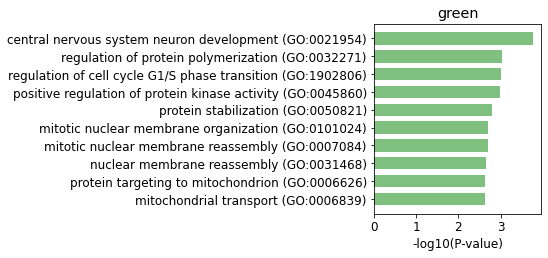

In [31]:
threshold = 0.01
gene_n = 10

for key in ['orange', 'navy', 'purple', 'red']:
    if key == 'red':
        color = 'green'
    else:
        color = key
    fig, ax = plt.subplots(figsize=[3, 3.5])
    rcParams['pdf.fonttype'] = 42
    rcParams['font.size'] = 12

    ax.barh(range(10), ellipse_show[key]['-log10(P-value)'][::-1], height=0.7, color=color, alpha=0.5)
    ax.set_yticks(range(10))
    ax.set_yticklabels(ellipse_show[key]['Term'][::-1])
    ax.set_title(color)

    ax.set_xlabel('-log10(P-value)')
    fig.savefig(save_figures + 'ellipse_gene_{}_quartile_{}_{}.pdf'.format(gene_n, threshold, key), 
                dpi=150, bbox_inches='tight')

In [197]:
# define a scatterplot to show genes in the UMAP created by PC1 and PC2
def PCA_plot(df, adata, gene, path, vmax=False, filetype=False,):
    PCA_gene = df[['PC1', 'PC2']][:-1].copy()
    PCA_gene['Gene exp'] = np.log10(adata[PCA_gene.index, gene].X[:, 0] + 0.1)
    PCA_gene['PC1'] = PCA_gene['PC1']/10e3
    PCA_gene['PC2'] = PCA_gene['PC2']/10e3
    vmin = -1
    if vmax == False:
        vmax = round(PCA_gene['Gene exp'].max())
    
    fig, ax = plt.subplots(figsize=[3, 3])
    rcParams['pdf.fonttype'] = 42
    rcParams['font.size'] = 12
    cmap = plt.cm.get_cmap('viridis')
    colors = [cmap((min(vmax, av) - vmin) / (vmax - vmin)) for av in PCA_gene['Gene exp']]
    sns.scatterplot(data=PCA_gene, x='PC1', y='PC2', s=100, c=colors, alpha=0.8)
    ax.set(xlabel='PC1 [×$10^3$]', ylabel='PC2 [×$10^3$]',
           xlim=[-1.2, 1.2], ylim=[-1.1, 1.3]
          )
    ax.set_title(gene)
    ax.set_aspect('equal', adjustable='box')
    ax.set_xticks([-1, -0.5, 0, 0.5, 1])
    ax.set_yticks([-1, -0.5, 0, 0.5, 1])

    norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax) 
    position = fig.add_axes([0.95, 0.15, 0.05, 0.7])
    cbar = plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), 
                 cax=position, ax=ax, label='Gene exp [cpm]')
    cbar.ax.set_yticks([np.log10(i + 0.1) for i in [10**i for i in range(vmin, vmax+1)]])
    cbar.ax.set_yticklabels(['0', '1', '10'] + ['$10^{}$'.format(str(i)) for i in range(2, vmax+1)])
    
    if filetype is not False:
        fig.savefig(os.path.join(path, 'PCA_plot_{}'.format(gene) + filetype), dpi=150, bbox_inches='tight')

/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)
/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)
/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)
/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categor

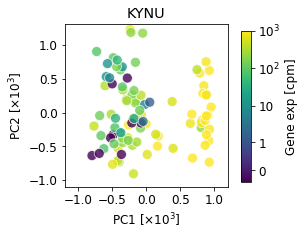

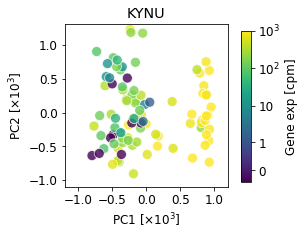

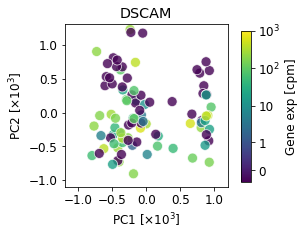

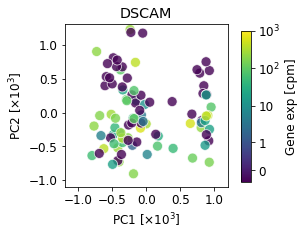

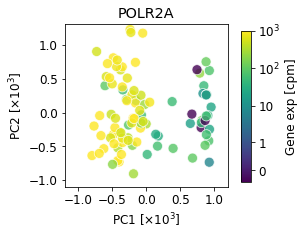

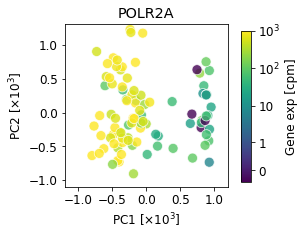

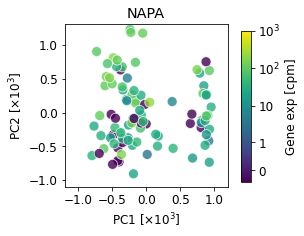

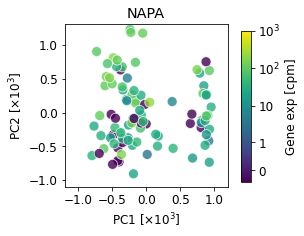

In [199]:
for gene in ['KYNU', 'DSCAM', 'POLR2A', 'NAPA']:
    PCA_plot(PCA_df, adata, gene, save_figures, vmax=3, filetype='.pdf',)
    PCA_plot(PCA_df, adata, gene, save_figures, vmax=3, filetype='.png',)

In [24]:
# PPP3CA: ATPase binding activity
# KYNU: involved in the biosynthesis of NAD cofactors from tryptophan through the kynurenine pathway

# POLR2A: This gene encodes the largest subunit of RNA polymerase II

# DSCAM, ABHD12: nervous system

# NAPA: Required for vesicular transport between the endoplasmic reticulum and the Golgi apparatus (Probable)

df[df['ellipse'] == 'purple'].sort_values(['PC2'])

,PC1,PC2,Frac,Number,ellipse
gene_name,,,,,
CEP78,0.019233,-0.421996,33.684211,32,purple
EEF2K,-0.108627,-0.399692,28.421053,27,purple
RCAN3,0.244082,-0.363874,12.631579,12,purple
FBXL16,0.121819,-0.340846,10.526316,10,purple
FAM21A,0.107104,-0.335762,43.157895,41,purple
COBL,0.052594,-0.323015,13.684211,13,purple
DSCAM,-0.078936,-0.321152,55.789474,53,purple
ERC2,-0.172593,-0.320343,32.631579,31,purple
REV3L,0.015115,-0.319336,52.631579,50,purple


In [118]:
# save as a supplementary table

a = df[df['ellipse'] != 'gray']
a.rename(columns={'ellipse': 'Group', 
                  'Frac': 'Cell_exp_frac',
                  'Number': 'Cell_exp_frac',
                  'PC1': 'ρ[PC1_vs_Exp]',
                  'PC2': 'ρ[PC2_vs_Exp]',
                 }).to_csv('/home/yike/phd/cancer_cells_img_seq/docs/hyperspectral_sequencing_ewa/tables/ML_sig_genes.tsv', sep='\t')

In [115]:
corr = pd.read_csv(save_figures + 'correlation_PCA.tsv', sep='\t', index_col=0)

In [118]:
ave_exp = pd.Series(adata.X.mean(axis=0), index=adata.var_names)

In [120]:
corr['ave_exp'] = ave_exp.loc[corr.index]

In [151]:
corr.loc[corr.index.str.startswith("NDUF")].fillna(0).sort_values("PC2")

,PC1,PC2,Frac,Number,ave_exp
gene_name,,,,,
NDUFV2P1,0.387016,-0.331519,11.578947,11,0.543938
NDUFB2-AS1,0.162226,-0.228064,2.105263,2,0.049133
NDUFS1,0.426654,-0.200475,51.578947,49,36.441475
NDUFAF4P2,-0.177705,-0.154775,1.052632,1,0.016517
NDUFA9P1,0.203396,-0.148639,3.157895,3,1.007853
...,...,...,...,...,...
NDUFA6,0.612833,0.089646,61.052632,58,139.798218
NDUFA6-AS1,-0.159817,0.093980,5.263158,5,4.825885
NDUFB9,0.096822,0.131658,87.368421,83,468.928894


In [155]:
corr.fillna(0).sort_values('PC2', ascending=False)[:50]

,PC1,PC2,Frac,Number,ave_exp
gene_name,,,,,
NAPA,-0.125064,0.419627,80.000000,76,46.501095
NR1H3,-0.138081,0.385215,18.947368,18,8.641076
RPS26,-0.326245,0.336222,96.842105,92,427.057770
TAGLN2,-0.370528,0.329684,88.421053,84,333.483246
RPS26P3,-0.309124,0.329261,51.578947,49,3.091324
CLDND1,-0.206377,0.321611,67.368421,64,90.808670
PITRM1,-0.189011,0.317654,83.157895,79,154.978897
PTRH2,-0.248213,0.315184,90.526316,86,306.499634
CA2,0.240570,0.313864,33.684211,32,9.649340


In [154]:
corr.loc['HSA']

KeyError: 'HSA'

In [158]:
import gseapy as gp

In [235]:
pthw = gp.enrichr(gene_list=corr.fillna(0).sort_values('PC2', ascending=False)[:100].index.tolist(),
                     gene_sets=['KEGG_2016'], ## KEGG for metabolism
                     description='pathway',
                     cutoff = False).res2d

pthw_plot = pthw[:10]


/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/gseapy/enrichr.py:427: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.results = self.results.append(res, ignore_index=True)
2023-06-08 11:48:32,111 Warning: No enrich terms using library KEGG_2016 when cutoff = False


In [236]:
pthw_plot

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
0,KEGG_2016,Hepatitis C Homo sapiens hsa05160,4/133,0.004479,0.212208,0,0,6.385982,34.537105,PPP2CA;CDKN1A;PSME3;NR1H3
1,KEGG_2016,Spliceosome Homo sapiens hsa03040,4/134,0.004600,0.212208,0,0,6.336538,34.101645,HSPA8;TRA2B;RP9;HNRNPC
2,KEGG_2016,Antigen processing and presentation Homo sapie...,3/77,0.006789,0.212208,0,0,8.286152,41.368146,HSPA8;HSP90AA1;PSME3
3,KEGG_2016,Hippo signaling pathway Homo sapiens hsa04390,4/153,0.007318,0.212208,0,0,5.523210,27.160295,SMAD2;PPP2CA;DLG1;CDH1
4,KEGG_2016,Thyroid cancer Homo sapiens hsa05216,2/29,0.009203,0.213512,0,0,15.021164,70.422449,CDH1;TPM3
5,KEGG_2016,Fructose and mannose metabolism Homo sapiens h...,2/32,0.011135,0.215267,0,0,13.517007,60.795508,PFKFB2;ALDOA
6,KEGG_2016,Estrogen signaling pathway Homo sapiens hsa04915,3/99,0.013455,0.222969,0,0,6.380155,27.488267,HSPA8;HSP90AA1;FKBP5
7,KEGG_2016,Bladder cancer Homo sapiens hsa05219,2/41,0.017880,0.259267,0,0,10.392988,41.821870,CDKN1A;CDH1
8,KEGG_2016,N-Glycan biosynthesis Homo sapiens hsa00510,2/49,0.024991,0.322109,0,0,8.620495,31.803006,RPN1;ALG3
9,KEGG_2016,Legionellosis Homo sapiens hsa05134,2/55,0.030956,0.359086,0,0,7.642280,26.558443,EEF1A1;HSPA8


In [166]:
corr.fillna(0).sort_values('PC2', ascending=False)[:50]

,PC1,PC2,Frac,Number,ave_exp
gene_name,,,,,
NAPA,-0.125064,0.419627,80.000000,76,46.501095
NR1H3,-0.138081,0.385215,18.947368,18,8.641076
RPS26,-0.326245,0.336222,96.842105,92,427.057770
TAGLN2,-0.370528,0.329684,88.421053,84,333.483246
RPS26P3,-0.309124,0.329261,51.578947,49,3.091324
CLDND1,-0.206377,0.321611,67.368421,64,90.808670
PITRM1,-0.189011,0.317654,83.157895,79,154.978897
PTRH2,-0.248213,0.315184,90.526316,86,306.499634
CA2,0.240570,0.313864,33.684211,32,9.649340


In [172]:
KYNU_exp = pd.Series(adata[:, 'KYNU'].X[:, 0], index=adata.obs_names)

/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)


In [174]:
adata.obs['ave_intensity']

cell_name
C3_S1       [1322.36309209243, 3538.2264802770287, 7228.96...
H3_S6       [693.6905301821821, 1787.1163286897452, 5674.2...
I3_S7       [1995.307762973057, 5187.318942339962, 11495.0...
J3_S8       [2069.82060162273, 5476.528173599075, 9562.571...
K3_S9       [984.9722562415426, 2675.465688425794, 4476.03...
                                  ...                        
F12_S121    [1795.841573183651, 3890.466797096963, 8391.54...
G12_S122    [1333.1941194396848, 3773.82380494149, 7930.27...
H12_S123    [1016.8773960878415, 2922.1820067779986, 4608....
J12_S125    [1067.574217429221, 2979.69234397423, 7172.875...
K12_S126    [1116.5972452593771, 3130.5315385455183, 6895....
Name: ave_intensity, Length: 94, dtype: object

In [177]:
from scipy.stats import spearmanr

corrs_KYNU = []
for i in range(15):
    x = KYNU_exp.values
    y = [val[i] for val in adata.obs['ave_intensity'].values]
    cor = spearmanr(x, y)
    corrs_KYNU.append(cor[0])

In [178]:
corrs_KYNU

[0.15586716799417139,
 0.1796032115690779,
 0.173604150616833,
 0.22839075545781695,
 0.2884970095287434,
 0.2735644072066494,
 0.23613894020577667,
 -0.3198366821660134,
 -0.6085866641445503,
 -0.6359221442908037,
 -0.6779155709565184,
 -0.6799538061234257,
 -0.6730729554890436,
 -0.6691988631150637,
 -0.5581945521456928]

In [181]:
df = pd.DataFrame(index=adata.obs_names, columns=adata.obs['wavelengths'].iloc[0])
for i in df.index:
    df.loc[i] = adata.obs['spectra'].loc[i] / adata.obs['area'].loc[i]

In [189]:
corr_C = pd.read_csv('/home/yike/phd/cancer_cells_img_seq/figures/hyperspectral_images/correlate_features/channels_gene/' + 'spectra_gene_correlation.tsv', sep='\t', index_col=0)

<AxesSubplot: xlabel='431_594', ylabel='Density'>

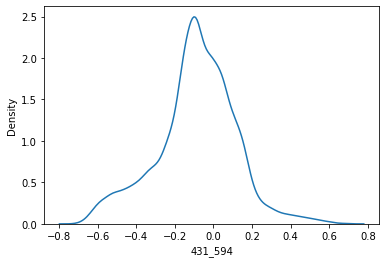

In [195]:
sns.kdeplot(corr_C[corr_C.columns[12]])

In [202]:
corr_C[corr_C.columns[12]].fillna(0).sort_values()[:20]

gene_name
IDI1      -0.713381
TUBA1A    -0.697493
C6orf62   -0.695647
TSPYL1    -0.689310
ZFYVE21   -0.686074
FTH1P20   -0.683490
PRDX5     -0.681683
DAAM1     -0.680554
NDUFB3    -0.674693
HNRNPA1   -0.674321
KYNU      -0.673579
LXN       -0.672826
SET       -0.672289
RPS2P46   -0.671353
RPL11     -0.670129
RPS2P5    -0.669583
MYL12A    -0.669444
PPP3CA    -0.669204
COPS6     -0.665667
PHB       -0.664243
Name: 431_594, dtype: float64

In [204]:
df.loc['C5_S27']

(325, 414)     3362.331639
(343, 414)     6461.371013
(370, 414)    13891.382476
(343, 451)     3398.766451
(370, 451)     4438.992156
(373, 451)     3103.697786
(343, 575)     1628.223028
(393, 575)     2077.287265
(406, 575)     1894.375709
(441, 575)      1688.26826
(400, 594)     1348.137632
(406, 594)     1457.330713
(431, 594)     1627.410723
(480, 594)     1363.481626
(339, 575)    20638.904957
Name: C5_S27, dtype: object

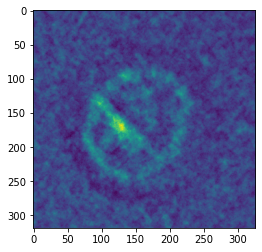

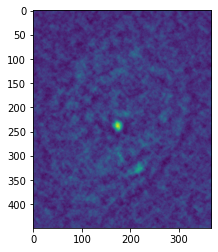

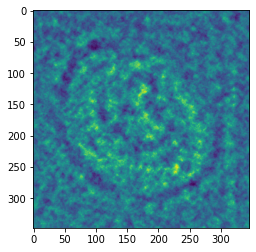

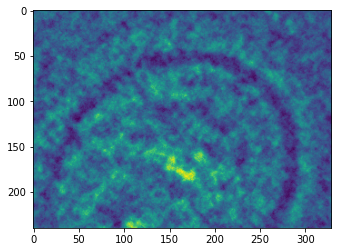

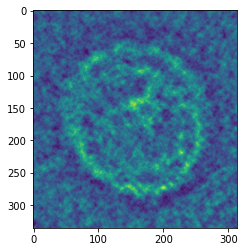

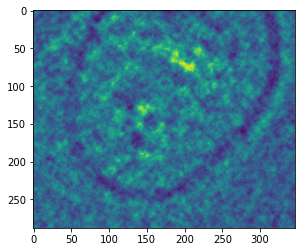

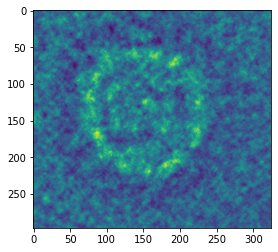

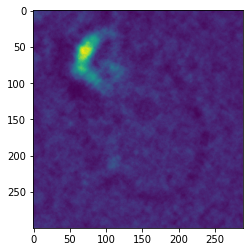

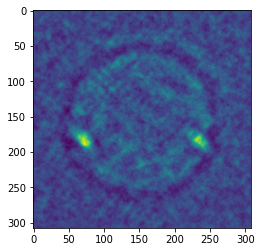

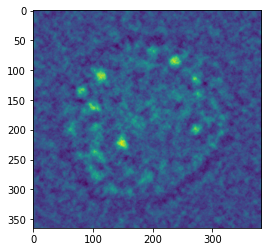

In [232]:
for name in df.sort_values(df.columns[12])[:10].index:
    sample = np.load('/home/yike/phd/cancer_cells_img_seq/figures/segmentation/cancer100cells/' + '{}.npz'.format(name))
    fig, ax = plt.subplots()
    ax.imshow(sample['wls_431_594'])# * sample['new_segmentation'])

In [238]:
import h5py

In [239]:
f = h5py.File('/home/yike/phd/cancer_cells_img_seq/data/20220201_imaging/dish1_M13.mat', 'r')

In [261]:
tmp = f['HAC_Image']['imageStruct']['protocol']['channel']['excitationWavelength']
tmpi = f[f[tmp[0, 0]][0, 0]][:, 0]
wl = int(tmpi.astype(dtype=np.uint8).tobytes().decode())

In [298]:
f['HAC_Image']['imageStruct']['data'].shape

(15, 4096, 4096)

In [274]:
f['HAC_Image']['imageStruct']['protocol']['channel'].keys()

<KeysViewHDF5 ['averages', 'distance', 'emGain', 'emission', 'excitationWavelength', 'exposure', 'filterCubes', 'focalPlanes', 'framesPerTimePoint', 'hardwareChannel', 'intensity', 'interpolationType', 'lampChan', 'lampID', 'lightsource', 'maxrange', 'minrange', 'prompt', 'radialityMagnification', 'ringRadius', 'sourceDesc', 'sourceNum', 'temporalAnalysisType', 'type']>

In [309]:
f[f[f['HAC_Image']['imageStruct']['protocol']['channel']['intensity'][12, 0]][0, 0]][:, 0].astype(dtype=np.uint8).tobytes()

b'100'

In [270]:
f[f[tmp[14, 0]][0, 0]][:, 0]

array([51, 51, 57], dtype=uint16)

In [ ]:
def read_image(fn):
    with h5py.File(fn, 'r') as f:
        print('Read metadata about excitation/emission lambdas')
        keys = ['excitationWavelength', 'emission']
        wls = {key: [] for key in keys}
        for key in keys:
            tmp = f['HAC_Image']['imageStruct']['protocol']['channel'][key]
            n_colors = tmp.size
            for i in range(n_colors):
                tmpi = f[f[tmp[i, 0]][0, 0]][:, 0]
                wl = int(tmpi.astype(dtype=np.uint8).tobytes().decode())
                wls[key].append(wl)
        wls['combo'] = []
        for i in range(n_colors):
            wls['combo'].append(
                (wls['excitationWavelength'][i], wls['emission'][i]),
                )

        print('Read image data')
        img = f['HAC_Image']['imageStruct']['data'][:, :, :]
    return {
        'data': img,
        'wavelengths': wls['combo'],
        'image': os.path.basename(fn).split('.')[0],
    }

In [329]:
f['HAC_Image']['projectStruct']['cellDesc'].keys()

<KeysViewHDF5 ['Passage', 'Source', 'WetlabPhaseFolder', 'cellTypes', 'confluence', 'cultureMedium', 'dishDescription', 'dishInternallygrided', 'imagingMediumUsed', 'incubatorGas', 'incubatorTemp', 'incubatorTime', 'preparation', 'viability']>

In [330]:
        print('Read metadata about excitation/emission lambdas')
        keys = ['excitationWavelength', 'emission']
        wls = {key: [] for key in keys}
        for key in keys:
            tmp = f['HAC_Image']['imageStruct']['protocol']['channel'][key]
            n_colors = tmp.size
            for i in range(n_colors):
                tmpi = f[f[tmp[i, 0]][0, 0]][:, 0]
                wl = int(tmpi.astype(dtype=np.uint8).tobytes().decode())
                wls[key].append(wl)
        wls['combo'] = []
        for i in range(n_colors):
            wls['combo'].append(
                (wls['excitationWavelength'][i], wls['emission'][i]),
                )

Read metadata about excitation/emission lambdas


In [7]:
group1 = X_r[:-1][X_r[:-1]['PC1'] < 500]['cell_name'].tolist()
group2 = X_r[:-1][X_r[:-1]['PC1'] > 500]['cell_name'].tolist()

In [10]:
len(group1)

64

In [23]:
data = X_r[:-1].set_index('cell_name').loc[adata.obs_names]
data.index = [j + '_' + i for i, j in zip(adata.obs_names, adata.obs['batch'])]

In [26]:
group1 = data[data['PC1'] < 500].index
group2 = data[data['PC1'] > 500].index

In [27]:
group2

Index(['1-2_E4_S16', '1-2_F4_S17', '1-2_H4_S19', '1-2_J4_S21', '1-2_K4_S22',
       '1-2_L4_S23', '1-2_M4_S24', '1-2_N4_S25', '1-2_C5_S27', '1-2_D5_S28',
       '1-2_E5_S29', '1-2_F5_S30', '1-2_G5_S31', '1-2_K5_S35', '1-2_L5_S36',
       '1-2_M5_S37', '1-2_N5_S38', '1-2_O5_S39', '1-2_C6_S40', '1-2_E6_S42',
       '1-2_F6_S43', '1-2_G6_S44', '1-2_H6_S45', '1-2_I6_S46', '1-2_J6_S47',
       '1-2_K6_S48', '1-1_M6_S50', '1-1_N6_S51', '1-1_O6_S52', '2-1_O11_S117'],
      dtype='object')

In [28]:
group1

Index(['1-1_C3_S1', '1-1_H3_S6', '1-1_I3_S7', '1-1_J3_S8', '1-1_K3_S9',
       '1-1_L3_S10', '1-1_M3_S11', '1-2_N3_S12', '1-2_O3_S13', '1-2_C4_S14',
       '2-1_C7_S53', '2-1_D7_S54', '2-1_E7_S55', '2-1_F7_S56', '2-1_G7_S57',
       '2-1_H7_S58', '2-1_I7_S59', '2-1_J7_S60', '2-1_K7_S61', '2-1_L7_S62',
       '2-1_M7_S63', '2-1_N7_S64', '2-1_O7_S65', '2-1_C8_S66', '2-1_D8_S67',
       '2-1_E8_S68', '2-1_F8_S69', '2-1_G8_S70', '2-1_H8_S71', '2-1_I8_S72',
       '2-1_J8_S73', '2-1_K8_S74', '2-1_O8_S78', '2-1_D9_S80', '2-1_E9_S81',
       '2-1_F9_S82', '2-1_G9_S83', '2-1_H9_S84', '2-1_I9_S85', '2-1_J9_S86',
       '2-1_C10_S92', '2-1_D10_S93', '2-1_G10_S96', '2-1_H10_S97',
       '2-1_I10_S98', '2-1_K10_S100', '2-1_L10_S101', '2-1_N10_S103',
       '2-1_O10_S104', '2-1_C11_S105', '2-1_D11_S106', '2-1_E11_S107',
       '2-1_F11_S108', '2-1_G11_S109', '2-1_H11_S110', '2-1_J11_S112',
       '2-1_K11_S113', '2-1_N11_S116', '2-1_C12_S118', '2-1_F12_S121',
       '2-1_G12_S122', '2-1_H12_S123', 

In [17]:
adata_nonlog = sc.read_h5ad('/home/yike/phd/cancer_cells_img_seq/data/20220201_NextSeq/gene_filter.h5ad')
adata_nonlog.var['mt'] = adata_nonlog.var_names.str.startswith('MT-')
sc.pp.calculate_qc_metrics(adata_nonlog, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)
/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)


Text(0.48, -0.05, 'Total counts [$10^5$]')

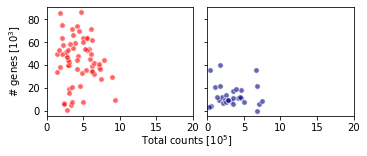

In [18]:
fig, axs = plt.subplots(1, 2, figsize=(5.5, 2), sharex=True, sharey=True)
plt.subplots_adjust(wspace=0.1)

for i, (group, color) in enumerate(zip([group1, group2], ['red', 'navy'])):
    temp = adata_nonlog[group, :]
    
    axs[i].scatter(x=temp.obs['total_counts']/(10**5), y=temp.obs['pct_counts_mt'], 
                   c=color, edgecolor='white', s=30, alpha=0.6)
    axs[0].set_xlim(0, 20)
    
axs[0].set_ylabel('mt counts [%]')
axs[0].set_ylabel('mt counts [%])
# axs[1].set_ylim(0, 80)
# axs[1].set_yticks([0, 2, 4, 6, 8, 10])

fig.text(0.48, -0.05, 'Total counts [$10^5$]', va='center', ha='center')

In [14]:
adata.obs['pct_counts_mt'].loc[group1].tolist()

[7.011112689971924,
 5.804898262023926,
 9.718809127807617,
 19.556596755981445,
 16.198699951171875,
 7.85454797744751,
 1.3883869647979736,
 8.390786170959473,
 6.238589286804199,
 34.35064697265625,
 48.82286071777344,
 22.163984298706055,
 59.73379135131836,
 52.03822708129883,
 53.04600524902344,
 39.75941467285156,
 41.76972961425781,
 63.75273513793945,
 71.62683868408203,
 38.20627975463867,
 37.136348724365234,
 34.6199836730957,
 47.849613189697266,
 58.00550079345703,
 71.496826171875,
 40.62156677246094,
 44.836971282958984,
 55.37084197998047,
 74.45938873291016,
 54.37013626098633,
 53.34807205200195,
 33.50824737548828,
 45.14079284667969,
 49.869041442871094,
 40.49100112915039,
 40.22441101074219,
 63.96371841430664,
 63.92316818237305,
 35.91592788696289,
 60.101478576660156,
 85.37590789794922,
 38.18191909790039,
 43.236549377441406,
 86.46082305908203,
 50.06221389770508,
 54.307891845703125,
 28.004234313964844,
 32.281219482421875,
 69.50273132324219,
 63.9837608

In [26]:
adata.obs['pct_counts_mt'].loc[group2]

cell_name
E4_S16       9.458955
F4_S17      21.338791
H4_S19       4.492323
J4_S21       7.610020
K4_S22       0.367944
L4_S23      11.687983
M4_S24      18.268547
N4_S25      39.891918
C5_S27      12.037333
D5_S28      13.802500
E5_S29      21.969372
F5_S30       9.579800
G5_S31      35.927979
K5_S35      11.204988
L5_S36      18.045937
M5_S37       4.043741
N5_S38      12.824401
O5_S39       8.383126
C6_S40       8.025126
E6_S42      12.687283
F6_S43       9.021094
G6_S44      11.313558
H6_S45       6.354708
I6_S46       8.828253
J6_S47       9.792495
K6_S48      22.060455
M6_S50      19.772156
N6_S51       6.686343
O6_S52       9.577521
O11_S117    36.033241
Name: pct_counts_mt, dtype: float32

### differentially expressed genes between group 1 and group 2

In [353]:
log2fc = pd.Series(np.log2(adata[group1,].X.mean(axis=0) + 1) - np.log2(adata[group2,].X.mean(axis=0) + 1),
                   index=adata.var_names)

/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)
/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)


In [359]:
log2fc.loc[log2fc.index.str.startswith("CASP")].sort_values()

gene_name
CASP9      -3.403121
CASP8AP2   -2.631475
CASP6      -2.595853
CASP4      -1.786073
CASP14     -1.327813
CASP3      -1.138278
CASP8      -0.141920
CASP7      -0.115701
CASP3P1     0.000000
CASP16      0.000000
CASP12      0.000000
CASP10      0.000000
CASP5       0.000000
CASP1       0.000000
CASP1P2     0.000000
CASP1P1     0.000000
CASP2       0.791160
dtype: float32

/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)
/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)


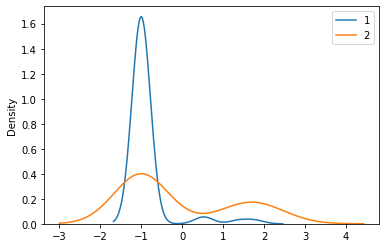

In [390]:
fig, ax = plt.subplots()
sns.kdeplot(np.log10(0.1 + adata[group1, 'CASP9'].X[:, 0]), ax=ax, label="1")
sns.kdeplot(np.log10(0.1 + adata[group2, 'CASP9'].X[:, 0]), ax=ax, label="2")
ax.legend()

In [363]:
adata[group1, 'CASP9'].X[:, 0]

/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)


ArrayView([ 0.       , 23.68258  ,  0.       ,  3.285939 ,  3.2225318,
            0.       ,  0.       , 59.557404 ,  0.       ,  0.       ,
            0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
            0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
            0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
            0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
            0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
            0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
            0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
            0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
            0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
            0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
            0.       ,  0.       ,  0.       ,  0.       ], dtype=float32)

In [388]:
mt_genes = adata.var_names.str.startswith('MT-')

(adata[group2,mt_genes].X.sum(axis=1))

/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)


ArrayView([ 94589.555 , 213387.92  ,  44923.227 ,  76100.21  ,
             3679.4373, 116879.81  , 182685.45  , 398919.2   ,
           120373.31  , 138025.    , 219693.69  ,  95797.99  ,
           359279.78  , 112049.88  , 180459.36  ,  40437.414 ,
           128244.    ,  83831.27  ,  80251.27  , 126872.85  ,
            90210.93  , 113135.59  ,  63547.086 ,  88282.52  ,
            97924.97  , 220604.55  , 197721.56  ,  66863.41  ,
            95775.22  , 360332.44  ], dtype=float32)

In [402]:
mt_pct_1 = pd.Series(adata[group1,mt_genes].X.sum(axis=1), index=group1)

/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)


In [407]:
mt_pct_1.sort_values()[-20:] 

K10_S100    543078.8750
I8_S72      543701.3125
G8_S70      553708.4375
C8_S66      580054.9375
D11_S106    582217.8125
E7_S55      597337.9375
J9_S86      601014.8125
H11_S110    619994.3125
J7_S60      637527.3125
H9_S84      639231.7500
G9_S83      639637.1875
C11_S105    639837.5000
H12_S123    660349.8125
O10_S104    695027.3125
D8_S67      714968.1250
K7_S61      716268.2500
H8_S71      744594.0625
K12_S126    751860.5625
C10_S92     853758.9375
H10_S97     864608.2500
dtype: float32

In [412]:
df.loc[group1].mean(axis=0)

(325, 414)     2848.190075
(343, 414)     5852.734706
(370, 414)    11476.050087
(343, 451)     3266.329268
(370, 451)     4065.330457
(373, 451)     2908.459273
(343, 575)     1530.835508
(393, 575)     2775.439244
(406, 575)     3835.479866
(441, 575)     4610.623759
(400, 594)     3770.717825
(406, 594)     4736.908134
(431, 594)     8197.027562
(480, 594)     7348.006844
(339, 575)    25269.402411
dtype: float64

In [413]:
df.loc[group2].mean(axis=0)

(325, 414)     3048.994661
(343, 414)     6287.131410
(370, 414)    12776.798425
(343, 451)     3623.160985
(370, 451)     4588.387681
(373, 451)     3255.683635
(343, 575)     1743.116751
(393, 575)     2230.293060
(406, 575)     2209.532180
(441, 575)     2228.980234
(400, 594)     1569.684661
(406, 594)     1747.373087
(431, 594)     2379.936534
(480, 594)     2142.770620
(339, 575)    20119.593665
dtype: float64

In [392]:
group2

['E4_S16',
 'F4_S17',
 'H4_S19',
 'J4_S21',
 'K4_S22',
 'L4_S23',
 'M4_S24',
 'N4_S25',
 'C5_S27',
 'D5_S28',
 'E5_S29',
 'F5_S30',
 'G5_S31',
 'K5_S35',
 'L5_S36',
 'M5_S37',
 'N5_S38',
 'O5_S39',
 'C6_S40',
 'E6_S42',
 'F6_S43',
 'G6_S44',
 'H6_S45',
 'I6_S46',
 'J6_S47',
 'K6_S48',
 'M6_S50',
 'N6_S51',
 'O6_S52',
 'O11_S117']

In [414]:
len(group2) / 52

0.5769230769230769

In [415]:
len(group1) / (126-52)

0.8648648648648649